<h2> 1. Exploratory Data Analysis </h2>
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
logins = pd.read_json('logins.json')
logins['count'] = 1
logins.set_index('login_time', inplace=True)

In [3]:
login15 = logins.resample('15T').sum().reset_index()
login15

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [4]:
login15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


<p style='text-align:center'> <b>On average there are 9 logins per day. The lowest amount of logins in a day was 0 and the highest was 73. How many times were there 0 logins? 73?</b>

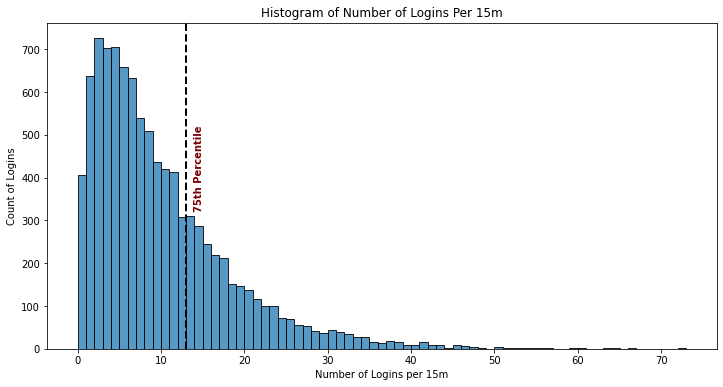

In [5]:
plt.figure(figsize=(12,6))
ax = sns.histplot(login15, label='Login Counts', binwidth=1, legend=False)
ax.set(xlabel='Number of Logins per 15m', ylabel='Count of Logins', title='Histogram of Number of Logins Per 15m');
ax.axvline(13, color='black', linestyle='--', linewidth=2)
ax.text(14,325, '75th Percentile', rotation=90, color='#780000', fontweight='semibold');

<p style='text-align:center'> <b>0 logins appears many times compared to 73 logins which happened only once. The number of logins typically range from 0-13</b></p>

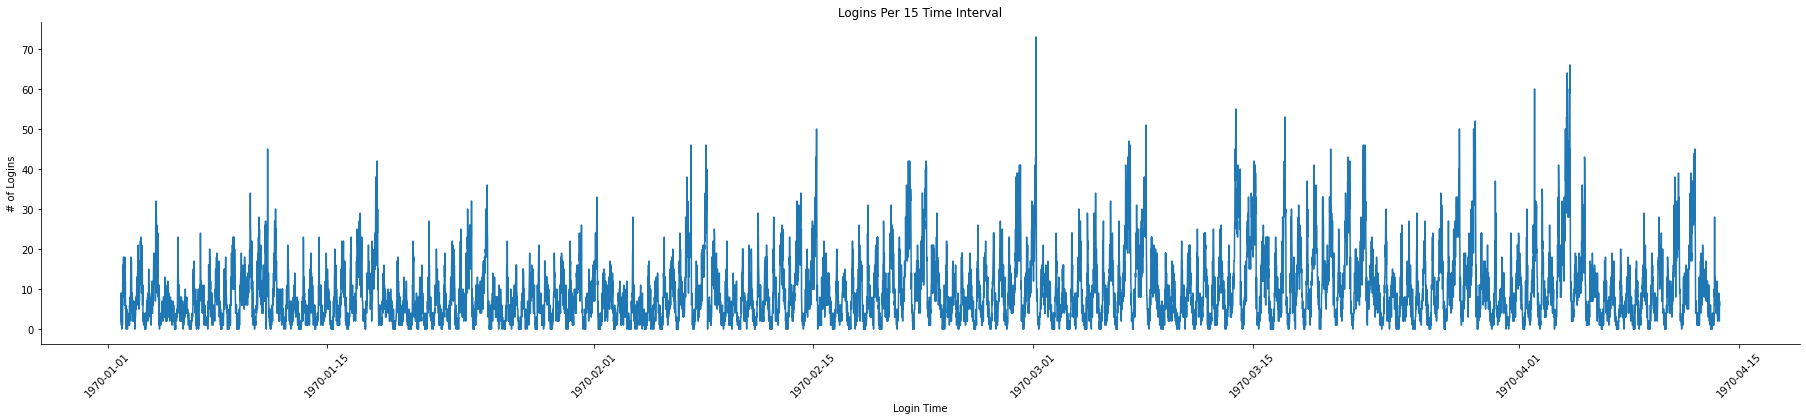

In [6]:
ax = sns.relplot(x='login_time',y='count', data=login15, kind='line', height=5, aspect=5)
ax.set(xlabel= 'Login Time', ylabel='# of Logins', title='Logins Per 15 Time Interval');
ax.set_xticklabels(rotation=45)

<p style='text-align:center'> <b>There appears to be some kind of a seasonality. Using statsmodels let's look at the trend of the data.</b> </p>

In [7]:
count_cycle, count_trend = sm.tsa.filters.hpfilter(login15['count'])

In [8]:
login15['trend'] = count_trend

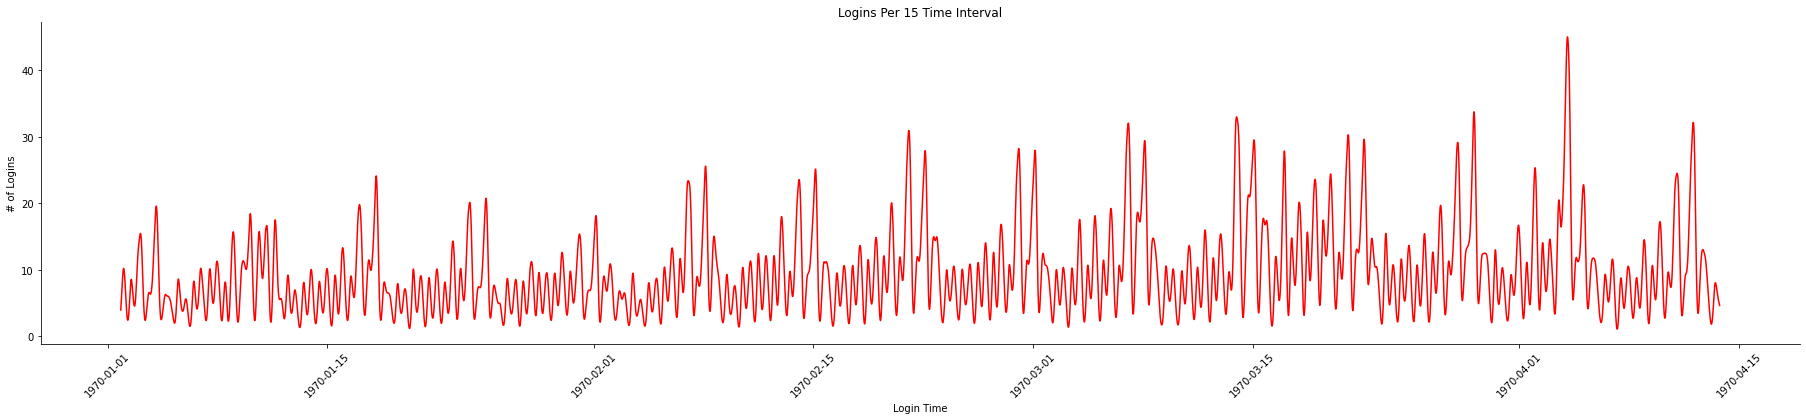

In [9]:
ax = sns.relplot(x='login_time',y='trend', data=login15, kind='line', color='red', height=5, aspect=5)
ax.set(xlabel= 'Login Time', ylabel='# of Logins', title='Logins Per 15 Time Interval');
ax.set_xticklabels(rotation=45)

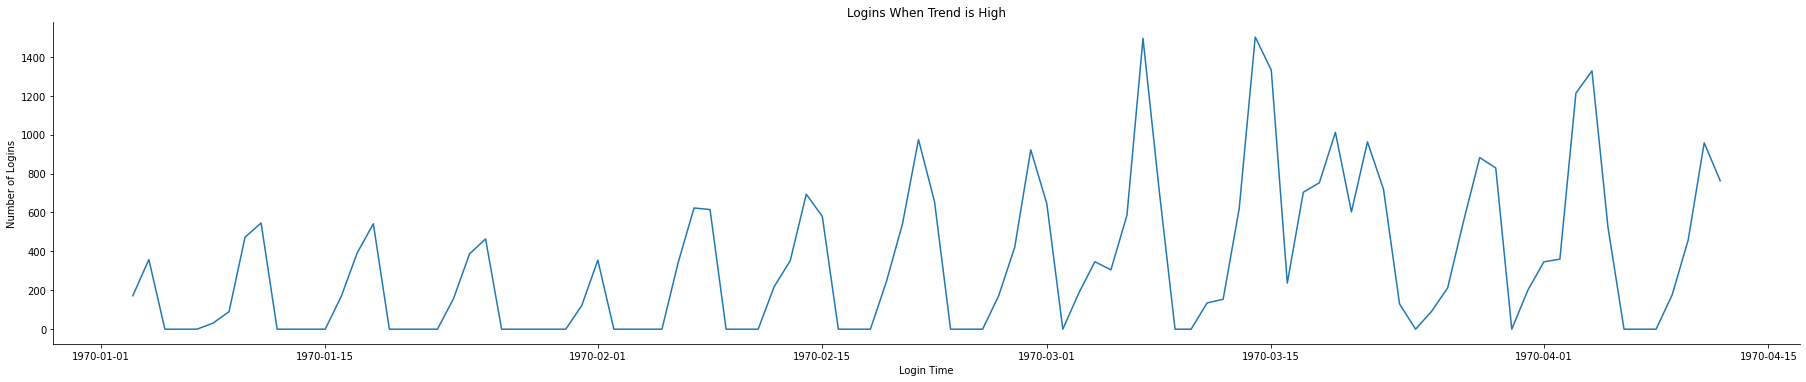

In [10]:
login_spike = pd.DataFrame(login15[login15['trend'] > 15].set_index('login_time').resample('D').sum()['count'])
ax = sns.relplot(x='login_time', y='count', data = login_spike.reset_index(), height=5, aspect=5, kind='line')
ax.set(xlabel='Login Time', ylabel='Number of Logins', title='Logins When Trend is High');

<p style='text-align:center'><b> Every week there is a spike in demand, the spikes have increased over time. </b></p>

In [11]:
login15['month'] = login15.login_time.dt.month
login15['week_of_month'] = (login15.login_time.dt.day - 1)//7 + 1
login15['day_of_week'] = login15.login_time.dt.dayofweek
login15['hour'] = login15.login_time.dt.hour

In [12]:
dow_map = {0: 'Monday',
           1: 'Tuesday',
           2: 'Wednesday',
           3: 'Thursday',
           4: 'Friday',
           5: 'Saturday',
           6: 'Sunday'}

login15.day_of_week = login15.day_of_week.map(dow_map)

In [13]:
login15.head()

,login_time,count,trend,month,week_of_month,day_of_week,hour
0,1970-01-01 20:00:00,2,3.969737,1,1,Thursday,20
1,1970-01-01 20:15:00,6,4.408149,1,1,Thursday,20
2,1970-01-01 20:30:00,9,4.845329,1,1,Thursday,20
3,1970-01-01 20:45:00,7,5.281042,1,1,Thursday,20
4,1970-01-01 21:00:00,1,5.717648,1,1,Thursday,21


In [14]:
login15.groupby('hour')['count'].mean()

hour
0     14.688725
1     15.482843
2     14.215686
3     11.840686
4     12.338235
5      7.218137
6      2.789216
7      1.997549
8      2.004902
9      3.742647
10     7.509804
11    14.213235
12    12.166667
13     8.850490
14     8.397059
15     7.446078
16     6.941176
17     6.333333
18     7.303922
19     8.007426
20    10.056373
21    13.781863
22    16.193627
23    14.848039
Name: count, dtype: float64

<p style='text-align:center'><b> In general people use the platform from 8PM to 4AM </b></p>

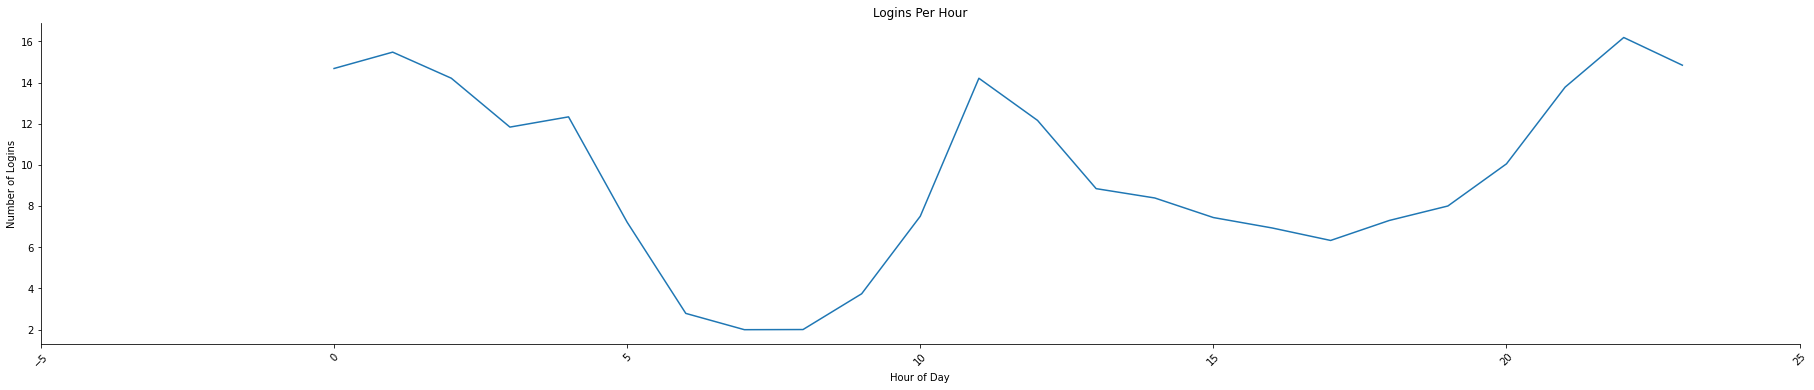

In [15]:
ax = sns.relplot(x='hour',y='count', data=pd.DataFrame(login15.groupby('hour')['count'].mean()), kind='line', height=5, aspect=5)
ax.set(xlabel='Hour of Day', ylabel='Number of Logins', title='Logins Per Hour')
ax.set_xticklabels(rotation=45)

In [16]:
login15.groupby('day_of_week')['count'].mean()

day_of_week
Friday       10.561111
Monday        6.213380
Saturday     13.456250
Sunday       12.615972
Thursday      8.794118
Tuesday       6.895833
Wednesday     7.692708
Name: count, dtype: float64

<p style='text-align:center'><b> In general people use the platform mainly on Friday, Saturday, & Sunday, which may be where the demand spikes are coming from every week. It appears as though the service is a late-night weekend service. It could possibly be a streaming service were people mainly use it after work on the weekdays and on the weekends </b></p>

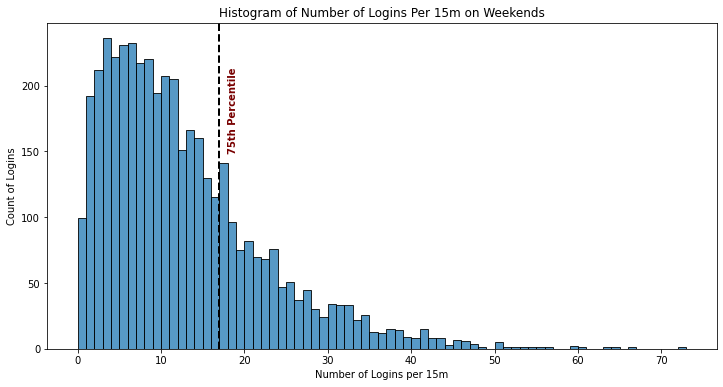

In [17]:
plt.figure(figsize=(12,6))
ax = sns.histplot(login15[login15.day_of_week.isin(['Friday','Saturday','Sunday'])]['count'], label='Login Counts', binwidth=1, legend=True)
ax.set(xlabel='Number of Logins per 15m', ylabel='Count of Logins', title='Histogram of Number of Logins Per 15m on Weekends');
ax.axvline(17, color='black', linestyle='--', linewidth=2)
ax.text(18,150, '75th Percentile', rotation=90, color='#780000', fontweight='semibold');

<p style='text-align:center'> <b> Compared to the general historgram of logins, when filterd by the weekends the number of 0 logins has decreased by about 300 steps and the 75th percentile has increase from 13 to 17.</b></p>

<h2> 2. Experiment & Metrics Design </h2>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.    

<h3 style="text-align:right"> 2.1 Key Measure of Success </h3>
<b>What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b><br />
The key measure of success I would look at is profit and if there is an increase after reimbursing all toll costs. The Ultimate managers don’t want drivers to serve both cities so the drivers can enjoy a change of scenery. By having drivers serve both cities they expand their network of cars without having to add more drivers. With an expanded network of cars, they can serve more users and increase the user experience via reduced wait times and driver availability. All of these benefits will be reflected in profit. If the initiative improves the service, then Ultimate’s profit should increase. Revenue might increase, but since they have to reimbursement the tolls that cost might eat into it, which is why the importance is on profit. 

<h3 style="text-align:right"> 2.2 Practical Experiment Design </h3>
<b>Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.</b><br />

To test the effectiveness of the initiative on profits I would use an A/B test where the test group is a subset of drivers that do get reimbursed for the tolls and the control group is a subset of drivers that don’t get reimbursed for the tolls. The hypothesis for the experiment is as follows:
<ul>
    <li> Null Hypothesis $H_0$: Reimbursing driver tolls has no impact on Ultimate’s profits.</li>
    <li> Alternate Hypothesis $H_1$: Reimbursing driver tolls has an impact on Ultimate’s profits.</li>
</ul>

The partition of the drivers into control and test groups should be random, however after the split two things should be checked before the experiment begins:
<ol>
<li> There should be about the same number of drivers from both types of driver partners, those typically exclusive to Gotham and those typically exclusive to Metropolis. </li>
<li> The distribution of profits for both groups should also be about the same. If drivers in one of group have higher profit levels beforehand, that would muddy the results and interpretation of the experiment.  
</ol>

Assuming the test is successful and reimbursing tolls increases profits I would want to see the percentage increase in profits. Additionally, profits for Ultimate and profits for their drivers are two different things. They might be getting toll reimbursements but going across the bridge increases the wear and tear on the vehicle as well as the gas consumed. Additionally, if the driver goes across the bridge for a trip and then never gets a trip that sends him back over, he would be responsible for the toll to get back home when he is done working (assuming they only reimburse when the driver is on duty). Something that might be worth further investigation is if they need to reimburse all toll costs or only toll costs at certain times, like how they have “hot-zones” that pay out double the money.
The last thing that should be evaluated is how sustainable the initiative is if things change, some factors that could affect the initiative are the toll costs, the number of driver partners, and the number of riders. 




<h2> 3. Predictive Modeling </h2>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.


In [18]:
riders = pd.read_json('ultimate_data_challenge.json')
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


<p style='text-align:center'><b> There are no rider IDs, but I assume that every individual row is a different rider. </b></p>

In [19]:
# What is the range of the dates we are working with?
riders['signup_date'].min(), riders['last_trip_date'].max()

('2014-01-01', '2014-07-01')

The earliest data is January 1, 2014 and the most "present" date that is available is July 1, 2014. 
<ul>
    <li>An assumption that I am making is that the 6th month for all the users is considered June 2014.</li>
    <li>Another assumption is that if the user's last trip was July 1 then they were also active in June</li>
</ul>

In [20]:
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'])
riders['signup_date'] = pd.to_datetime(riders['signup_date'])

In [21]:
# Were the users active in their first month?
riders['active_1'] = np.where(riders['trips_in_first_30_days']>0, 1, 0)

<p style='text-align:center'><b>Data Quality:</b> If the user has 0 trips in the first 30 days then the avg_dist should also be 0; being that the avg_dist is defined as the average distance in miles per trip taken in the first 30 days after signup. On the same note, the ultimate black column should always be false.<b> I am making the assumption that there is an error in the first 30 day trip column and if the avg_dist is greater than 0 then the user was active in the first month.</b></p>

In [22]:
riders.loc[((riders.trips_in_first_30_days==0)&(riders.avg_dist>0)),'active_1'] = 1
riders.loc[((riders.trips_in_first_30_days==0)&(riders.ultimate_black_user==1)),'active_1'] = 1

# If the number of trips and the avg_dist is 0 then they weren't active regardless of BLACK status
riders.loc[((riders.trips_in_first_30_days==0)&(riders.avg_dist==0)),'active_1'] = 0

In [23]:
riders.active_1.value_counts(normalize=True)

1    0.99888
0    0.00112
Name: active_1, dtype: float64

<p style='text-align:center'><b>Of the 50,000 users that signed up in the first month 99% (49,944) of them were active in the first month</b></p>

In [24]:
riders['active_6'] = np.where(riders['last_trip_date']>='2014-06-01',1,0)

In [25]:
riders.active_6.value_counts(normalize=True)

0    0.62392
1    0.37608
Name: active_6, dtype: float64

<p style='text-align:center'><b>Of the 50,000 users that signed up in the first month 62% (31,196) of them were active in the 6th month</b></p>

In [26]:
riders.city.value_counts(normalize=True)

Winterfell        0.46672
Astapor           0.33068
King's Landing    0.20260
Name: city, dtype: float64

<p style='text-align:center'><b>Nearly half of the riders are signing up from Winterfell</b></p>

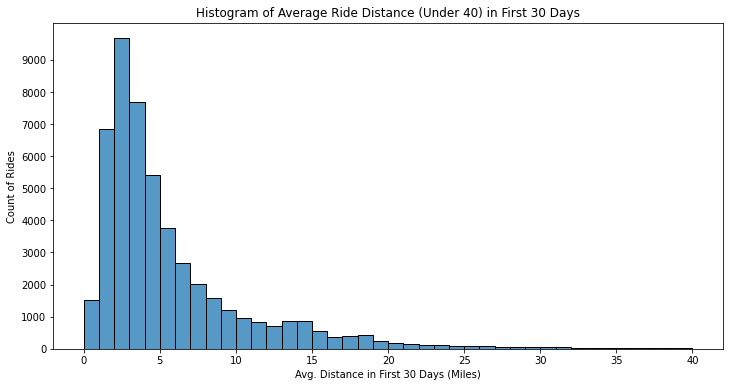

In [27]:
plt.figure(figsize=(12,6))
ax = sns.histplot(riders.avg_dist[riders.avg_dist < 40], label='Login Counts', binwidth=1, legend=True)
ax.set(xlabel='Avg. Distance in First 30 Days (Miles)', ylabel='Count of Rides', title='Histogram of Average Ride Distance (Under 40) in First 30 Days');
plt.yticks(np.arange(0,10000,1000));

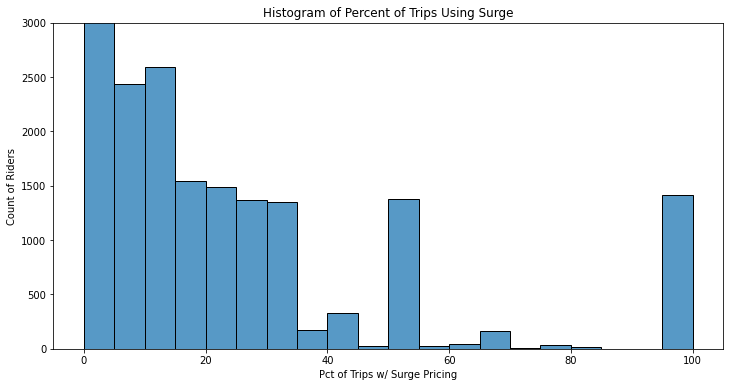

In [28]:
plt.figure(figsize=(12,6))
ax = sns.histplot(riders.surge_pct, binwidth=5, legend=True)
ax.set(xlabel='Pct of Trips w/ Surge Pricing', ylabel='Count of Riders', title='Histogram of Percent of Trips Using Surge', ylim=(0,3000));

<p style='text-align:center'><b>The majority of riders aren't using surge at all (35,000 people) and when they do it is well under a half of their trips.</b></p>

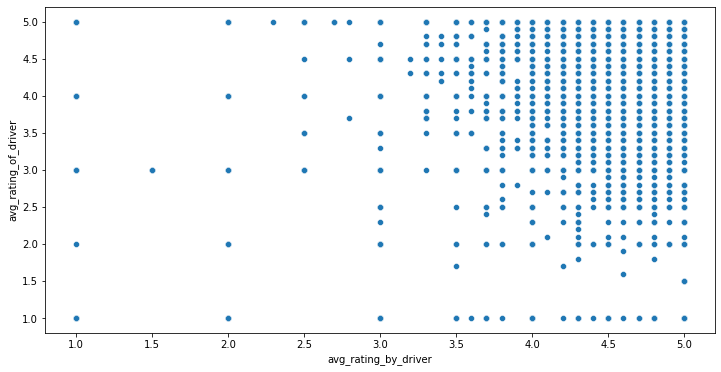

In [29]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='avg_rating_by_driver', y='avg_rating_of_driver', x_jitter=True, y_jitter=True, data=riders);

<p style='text-align:center'><b>Whether a passenger has high or low ratings they will get a high or low rated driver. However, there are not many low ratings in both groups.</b></p>

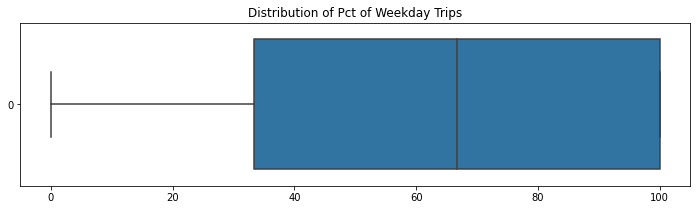

In [30]:
plt.figure(figsize=(12,3))
ax = sns.boxplot(data = riders['weekday_pct'], orient='h')
ax.set(title='Distribution of Pct of Weekday Trips');

<p style='text-align:center'><b>The service is mainly being used on the weekdays.</b></p>

In [31]:
riders.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_1                     0
active_6                     0
dtype: int64

In [32]:
# If the phone method is null I am going to fill it with 'Other'
riders.phone.fillna('Other', inplace=True)

# Fill the average rating by driver using the average
riders.avg_rating_by_driver.fillna(riders.avg_rating_by_driver.mean(), inplace=True)

<p style='text-align:center'><b>For the Avg Rating of Driver I am not going to just use the average because there are so many missing values.</b></p>

In [33]:
riders.avg_rating_of_driver.value_counts().head(10)

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
Name: avg_rating_of_driver, dtype: int64

In [34]:
riders.avg_rating_of_driver.describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

<p style='text-align:center'><b>I am going to fill NaN values by pulling from a normal distribution instead of filling it with the average.</b></p>

In [35]:
random_fills = np.random.normal(4.6,0.6,8122)
random_fills = np.round(random_fills,1)

In [36]:
trunc_random_fills = []
for value in random_fills:
    if value > 5:
        trunc_random_fills.append(5.0)
    else:
        trunc_random_fills.append(value)
trunc_random_fills = pd.Series(trunc_random_fills, index=riders[riders.avg_rating_of_driver.isna()].index)

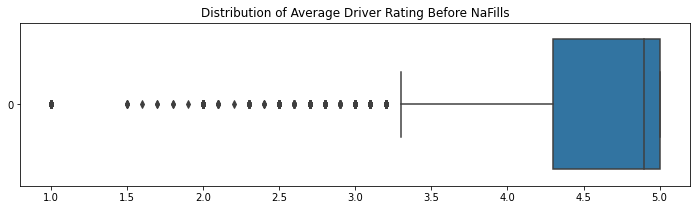

In [37]:
plt.figure(figsize=(12,3))
ax = sns.boxplot(data = riders['avg_rating_of_driver'], orient='h')
ax.set(title='Distribution of Average Driver Rating Before NaFills');

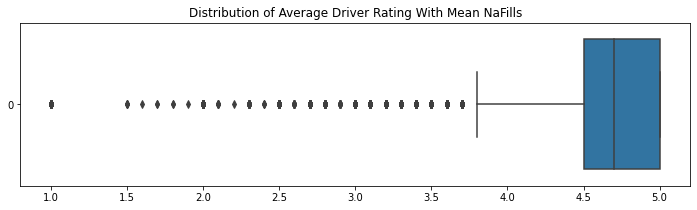

In [38]:
plt.figure(figsize=(12,3))
ax = sns.boxplot(data = riders['avg_rating_of_driver'].fillna(riders.avg_rating_of_driver.mean()), orient='h')
ax.set(title='Distribution of Average Driver Rating With Mean NaFills');

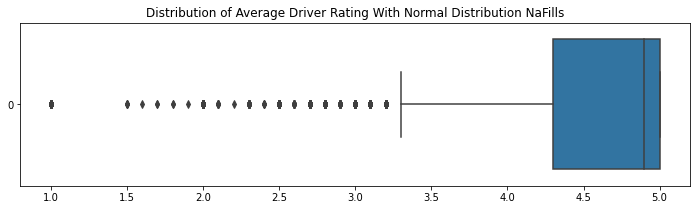

In [39]:
plt.figure(figsize=(12,3))
ax = sns.boxplot(data = riders['avg_rating_of_driver'].fillna(trunc_random_fills), orient='h')
ax.set(title='Distribution of Average Driver Rating With Normal Distribution NaFills');

In [40]:
riders.avg_rating_of_driver.fillna(trunc_random_fills, inplace=True)

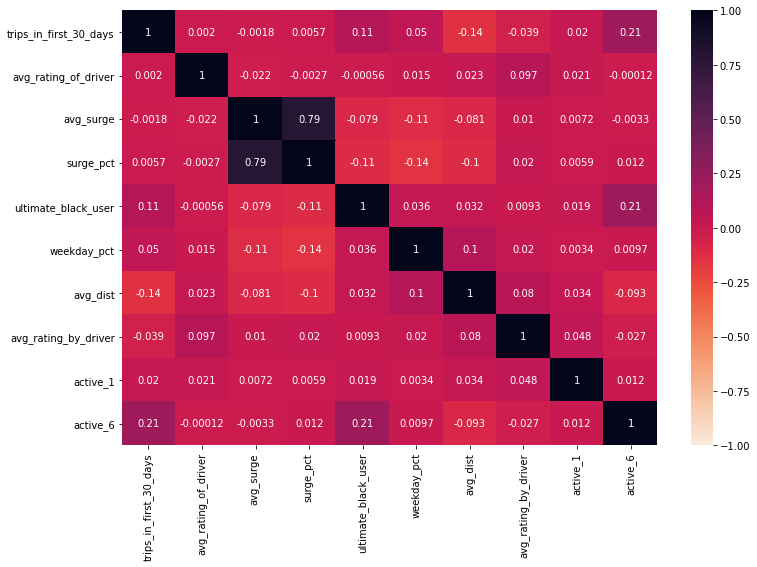

In [41]:
plt.figure(figsize=(12,8))
sns.heatmap(riders.corr(), cmap='rocket_r', vmin=-1, vmax=1, center=0, annot=True);

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
riders = pd.get_dummies(riders, drop_first=True)

In [44]:
X = riders.drop(columns=['active_6','signup_date','last_trip_date'])
y = riders.active_6

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = np.array(X_train)
y_train = np.array(y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h3>Logistic Regression</h3>

In [46]:
cv = StratifiedKFold()
logistic_model = LogisticRegressionCV(cv=cv)

In [47]:
logistic_model.fit(X_train, y_train)

LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False))

In [48]:
log_pred = logistic_model.predict(X_test)

In [49]:
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      6204
           1       0.68      0.49      0.57      3796

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



In [50]:
confusion_matrix(y_test,log_pred)

array([[5307,  897],
       [1933, 1863]], dtype=int64)

<h3>K Nearest Neighbors </h3>

In [51]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [52]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      6204
           1       0.67      0.62      0.65      3796

    accuracy                           0.74     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.74      0.74      0.74     10000



In [53]:
confusion_matrix(y_test,knn_pred)

array([[5060, 1144],
       [1432, 2364]], dtype=int64)

<h3>Support Vector Classifier</h3>

In [54]:
support = SVC()
support.fit(X_train, y_train)
support_pred = support.predict(X_test)

In [55]:
print(classification_report(y_test, support_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      6204
           1       0.74      0.60      0.66      3796

    accuracy                           0.77     10000
   macro avg       0.76      0.73      0.74     10000
weighted avg       0.76      0.77      0.76     10000



In [56]:
confusion_matrix(y_test,support_pred)

array([[5397,  807],
       [1533, 2263]], dtype=int64)

<h3>Random Forest</h3>

In [57]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

In [58]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      6204
           1       0.69      0.65      0.67      3796

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000



In [59]:
confusion_matrix(y_test,forest_pred)

array([[5104, 1100],
       [1321, 2475]], dtype=int64)

<p style='text-align:center'> <b>If the initiative is to understand what customers won't be active and then implement strategies to make them active then False Positives are more costly. Which means we are looking for a good precision value. The model that is chosen is the Support Vector Classifier. The precision metrics overall are better and it has better metrics in the other categories. However, if the business wants to know which features are the most important to retention then the random forest model will be picked (<i>The Linear SVC Kernel doesn't perform as well as the Random Forest</i>). The hyperparameters for the forest model could be tuned to better fit the model, but for  the purposes of this assignment I will stick with the base model.</b></p>

In [60]:
feature_importance = pd.DataFrame(forest.feature_importances_)

In [61]:
feature_importance.index = X.columns

In [62]:
feature_importance.sort_values(by=0, ascending=False)

,0
avg_dist,0.290679
weekday_pct,0.131124
avg_rating_by_driver,0.117106
avg_rating_of_driver,0.088234
surge_pct,0.086286
trips_in_first_30_days,0.079347
avg_surge,0.063860
city_King's Landing,0.061745
phone_iPhone,0.033990
ultimate_black_user,0.030957


The top two important features when it comes to predicting whether a user will be active in the next 6 months is the Average Distance in the First 30 Days and the Percent of Trips Taken on Weekdays. I believe that weekdays play an important role in the prediction becasue weekday trips could be more of a need than a want. Typically, the main communte on weekdays is to/from work. If the user is using the service for work then it is likely that they will use it for work again at some point in the future. With that idea, an incentive program could be implemented for when users take a trip from work. A possible program could be:
<ul>
    <li> Have the user set a 30m window that is designated as "work", for example 8:00 - 8:30. When the rider requests a ride during that window on Monday - Friday they receive either a small discount or credits toward a future ride. To avoid people abusing the system, a lock could be put on the time window where they can only change the window once every $X$ amount of months. Another incenctive could be lowering the surge pricing if that window is set during typical surge times</li>
</ul>

When it comes to the average distance the company can examine where are the drop-off hotspots and try to expand the network of drivers to places that are farther away from those hotspots. This expansion would have to somehow incentivize drivers as it's ultimately up to chose where to circulate and pickup rides. Drivers wouldn't want to drive farther for less money, however if the longer ride ends in a hotspot and then there was a limited-bonus for picking up rides in that area that might incentive drivers go to the farther locations which might might improve rider retention by proxy. 